In [18]:
import geopandas as gpd
import networkx as nx
from libpysal.weights import Queen, KNN

import numpy as np
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gdf = gpd.read_file('data/矢量/grid.shp')

In [3]:
gdf

,ENG_NAME,FID,geometry
0,Xinjiang,0,"POLYGON ((73.45746 38.22640, 73.45746 38.72640..."
1,Xinjiang,1,"POLYGON ((73.45746 38.72640, 73.45746 39.22640..."
2,Xinjiang,2,"POLYGON ((73.45746 39.22640, 73.45746 39.72640..."
3,Xinjiang,3,"POLYGON ((73.45746 39.72640, 73.45746 40.22640..."
4,Xinjiang,4,"POLYGON ((73.95746 38.22640, 73.95746 38.72640..."
...,...,...,...
5234,Heilongjiang,5234,"POLYGON ((133.95746 48.22640, 133.95746 48.726..."
5235,Heilongjiang,5235,"POLYGON ((134.45746 47.22640, 134.45746 47.726..."
5236,Heilongjiang,5236,"POLYGON ((134.45746 47.72640, 134.45746 48.226..."
5237,Heilongjiang,5237,"POLYGON ((134.45746 48.22640, 134.45746 48.726..."


## 空间权重矩阵
- 参考: [A graph neural network framework for spatial geodemographic classification](https://www.tandfonline.com/doi/full/10.1080/13658816.2023.2254382)  

- 使用图神经网络进行空间预测

In [28]:
def haversine(coord1, coord2):
    # 地球半径，单位为公里
    R = 6371.0  
    lat1, lon1 = np.radians(coord1)
    lat2, lon2 = np.radians(coord2)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c  # 返回距离，单位为公里

### Queen’s contiguity

In [33]:
w = Queen.from_dataframe(gdf, use_index=True)  #  构建邻接矩阵 (Queen 邻接关系)
adj_matrix = w.sparse  # 将邻接矩阵转换为稀疏矩阵格式

D:\Anaconda3\envs\Math\lib\site-packages\libpysal\weights\contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 14 disconnected components.
 There are 4 islands with ids: 3258, 3703, 3936, 4880.
  W.__init__(self, neighbors, ids=ids, **kw)


C:\Users\15499\AppData\Local\Temp\ipykernel_19732\2700156124.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.geometry.centroid


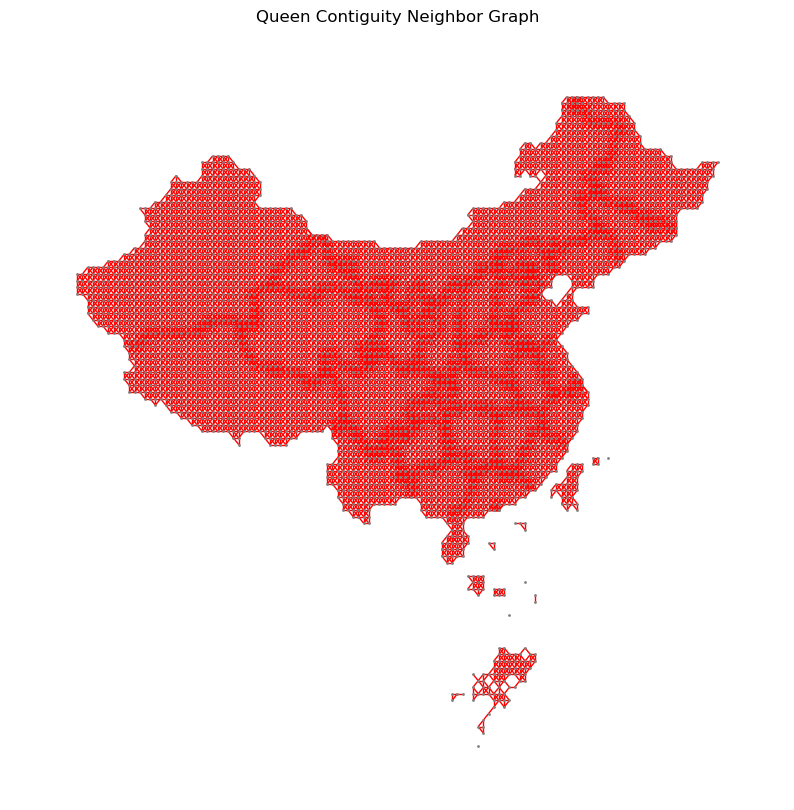

In [34]:
G = nx.from_numpy_array(adj_matrix)
# 提取几何的中心点作为节点位置
centroids = gdf.geometry.centroid
pos = {i: (centroid.x, centroid.y) for i, centroid in enumerate(centroids)}

# 绘制图形
fig, ax = plt.subplots(figsize=(10, 10))
# gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
nx.draw(
    G, pos,
    ax=ax,
    node_size=1,
    node_color="grey",
    edge_color="red",
    with_labels=False
)
plt.title('Queen Contiguity Neighbor Graph')
plt.show()

In [29]:
centroids = gdf.geometry.centroid  # 获取每个要素的几何中心点
coords = centroids.apply(lambda point: (point.y, point.x)).tolist()  # 提取经纬度
dist_matrix = squareform(pdist(coords, metric=haversine))  # 使用 pdist 和 haversine 计算距离矩阵
# 使用距离的倒数作为权重矩阵
weight_matrix = 1 / (dist_matrix + np.eye(dist_matrix.shape[0]))  # 避免除以 0

C:\Users\15499\AppData\Local\Temp\ipykernel_19732\1893170252.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.geometry.centroid  # 获取每个要素的几何中心点
C:\Users\15499\AppData\Local\Temp\ipykernel_19732\1893170252.py:5: RuntimeWarning: divide by zero encountered in divide
  weight_matrix = 1 / (dist_matrix + np.eye(dist_matrix.shape[0]))  # 避免除以 0


In [30]:
weight_matrix

array([[1.00000000e+00, 1.79864321e-02, 8.99321606e-03, ...,
        2.03230350e-04, 2.03664186e-04, 2.02173308e-04],
       [1.79864321e-02, 1.00000000e+00, 1.79864321e-02, ...,
        2.04479985e-04, 2.04943257e-04, 2.03436721e-04],
       [8.99321606e-03, 1.79864321e-02, 1.00000000e+00, ...,
        2.05729953e-04, 2.06223482e-04, 2.04701430e-04],
       ...,
       [2.03230350e-04, 2.04479985e-04, 2.05729953e-04, ...,
        1.00000000e+00, 1.79864321e-02, 1.49689938e-02],
       [2.03664186e-04, 2.04943257e-04, 2.06223482e-04, ...,
        1.79864321e-02, 1.00000000e+00, 2.71318329e-02],
       [2.02173308e-04, 2.03436721e-04, 2.04701430e-04, ...,
        1.49689938e-02, 2.71318329e-02, 1.00000000e+00]])

In [31]:
weight_matrix.shape

(5239, 5239)

### K-nearest neighbours (KNN)

In [26]:
# 使用KNN构建邻接矩阵，k表示邻居个数
k = 7
knn = KNN.from_dataframe(gdf, k=k)
adj_matrix = knn.sparse

C:\Users\15499\AppData\Local\Temp\ipykernel_19732\2338306677.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.geometry.centroid


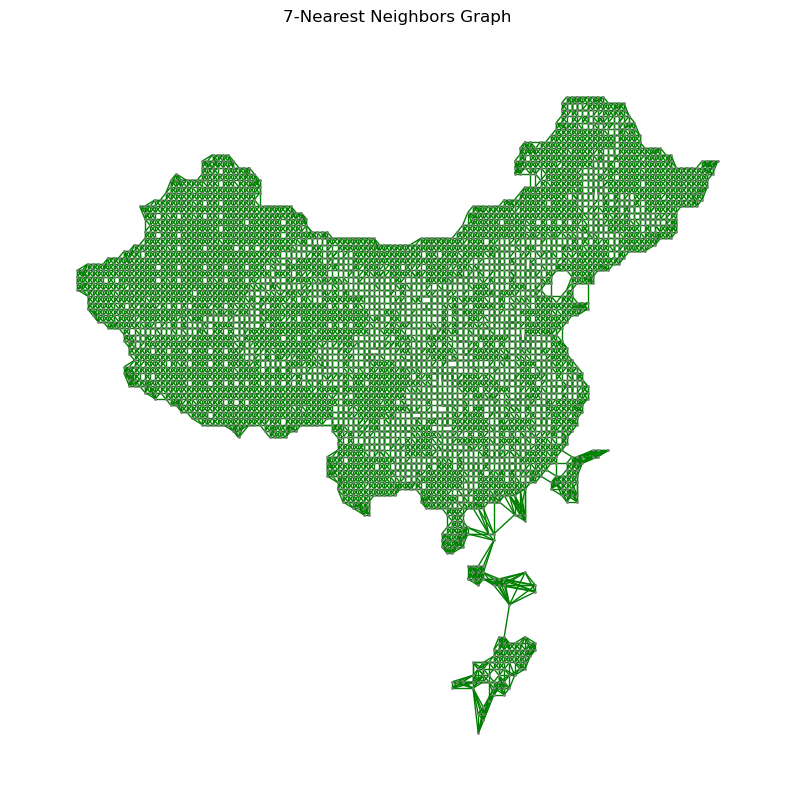

In [27]:
G = nx.from_numpy_array(adj_matrix)

centroids = gdf.geometry.centroid
pos = {i: (centroid.x, centroid.y) for i, centroid in enumerate(centroids)}

# 绘制图形
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(
    G, pos,
    ax=ax,
    node_size=1,
    node_color="grey",
    edge_color="green",
    with_labels=False
)
plt.title(f'{k}-Nearest Neighbors Graph')
plt.show()